# Fusion of three ideas: Deep Image Prior, CSGM, AE. DIP is a type of CSGM but uses the CNN architecture as the prior. CSGM trains a generative model, but these are expensive to train. We will train a simple non-probabilistic AE and then minimize energy like DIP.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr

/home/remedios/kaisr/kaisr


In [3]:
import nibabel as nib
import numpy as np
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import torch

from utils.plot import *
from tqdm import tqdm
from models.convnext_ae import *
import lpips

In [4]:
torch.backends.cudnn.benchmark = True
set_display_mode(mode='dark')
DTYPE = np.float32
device = torch.device(f'cuda:0')

In [136]:
fpath = Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")
vol = nib.load(fpath).get_fdata(dtype=DTYPE)

fpath = Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-01mm_resampled.nii")
vol = nib.load(fpath).get_fdata(dtype=DTYPE)

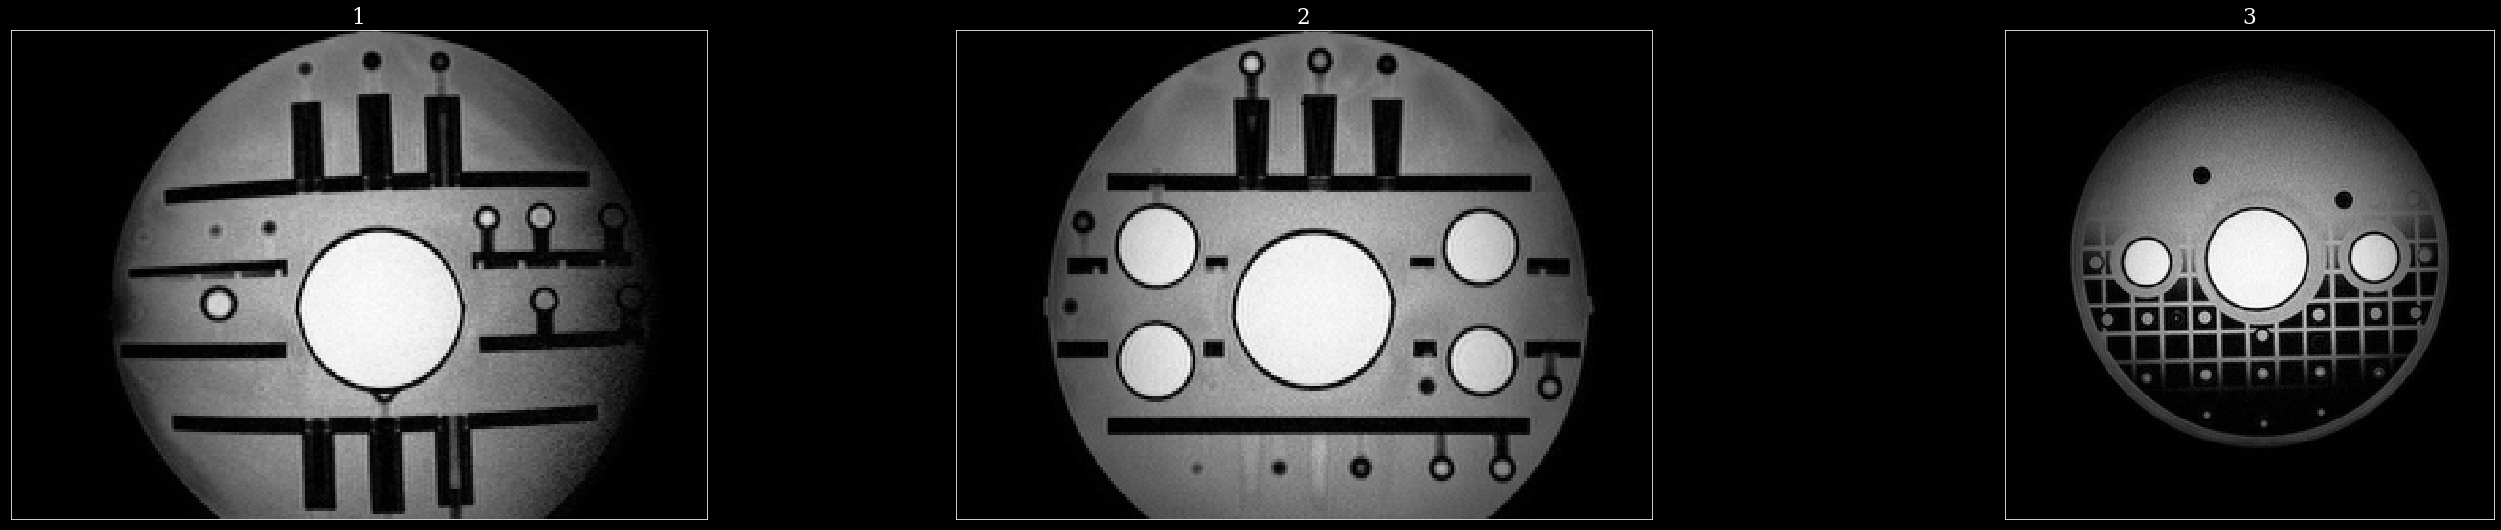

In [137]:
center_vol_plot(vol, target_shape=(256, 256, 180))

In [138]:
from utils.train_loader_patches import TrainSet
from torch.utils.data import DataLoader

In [139]:
batch_size = 32
patch_size = 64
n_iters = 32000

In [140]:
ds = TrainSet(
    img_fpath=fpath,
    patch_size=patch_size,
    n_patches=batch_size*n_iters,
    patch_axis=0,
    augment=True,
    dtype=np.float32,
)

data_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True, 
    pin_memory=True,
    num_workers=4,
)

In [141]:
model = ConvNeXtAE(
    in_chans=1,
    depths=[3, 3, 9, 3], 
    dims=[96, 192, 384, 768], 
    layer_scale_init_value=1e-6,
).to(device)

In [142]:
lr = 1e-4
opt = torch.optim.AdamW(model.parameters(), lr=lr)

In [143]:
N_STEPS = n_iters
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt,
    max_lr=lr,
    total_steps=N_STEPS+1,
    cycle_momentum=True,
)
opt.zero_grad()
opt.step()

In [144]:
recon_loss = nn.MSELoss()
lpips_loss = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/remedios/miniconda3/envs/kaisr/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [145]:
with tqdm(total=n_iters) as pbar:    
    pbar_dict = {
        'loss': np.finfo(np.float32).max,
        'mse': np.finfo(np.float32).max,
        'lpips': np.finfo(np.float32).max,
    }
    
    for cur_step, imgs in enumerate(data_loader):
        opt.zero_grad()

        x = imgs.to(device)
        x_hat = model(x)

        recon_loss_val = recon_loss(x_hat, x)
        lpips_loss_val = lpips_loss(x_hat, x).mean()
        loss = recon_loss_val + lpips_loss_val
        
        loss.backward()
        opt.step()

        scheduler.step()

        pbar_dict['loss'] = loss.detach().cpu().numpy().item()
        pbar_dict['mse'] = recon_loss_val.detach().cpu().numpy().item()
        pbar_dict['lpips'] = lpips_loss_val.detach().cpu().numpy().item()

        pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████| 32000/32000 [49:00<00:00, 10.88it/s, loss=0.0357, mse=0.0018, lpips=0.0339]


In [146]:
from utils.train_loader_slices import TrainSet as TrainSetSlices

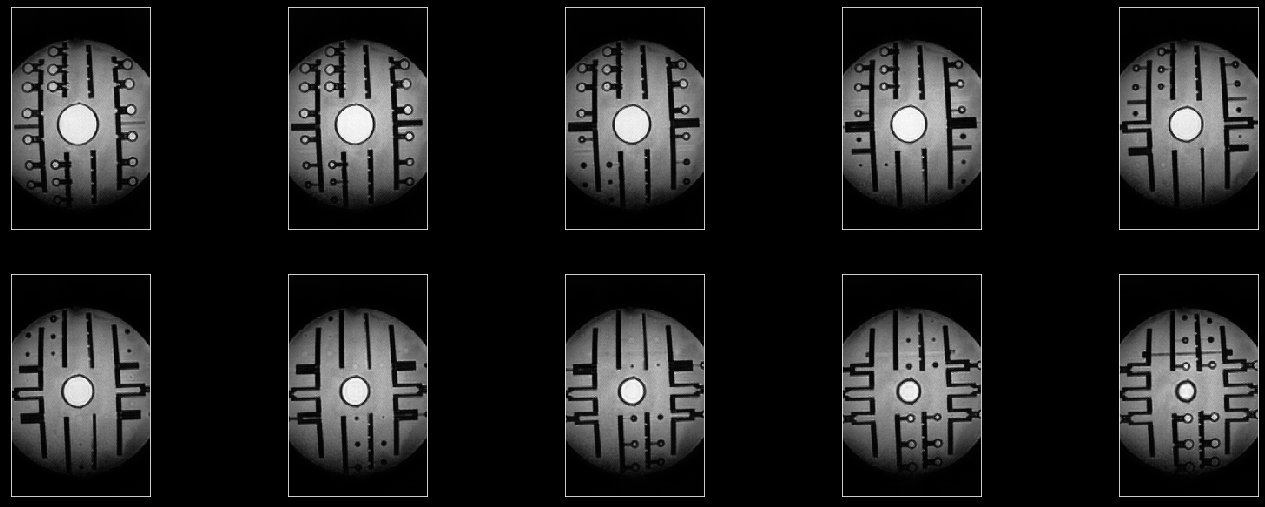

In [153]:
# visualize 16 encodings of slices
ds_slices = TrainSetSlices(img_fpath=fpath, n_iters=1, slice_axis=0)
# gts = [ds_slices.__getitem__(i) for i in range(16, 16+10)]
gts = [ds_slices.__getitem__(i) for i in range(150, 150+10)]

gts = torch.from_numpy(np.array(gts)).to(device)

encodings = model(gts).detach().cpu().numpy().squeeze()

fig, axs = plt.subplots(2, 5, figsize=(24, 9))
for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[i])
    ax.set_xticks([])
    ax.set_yticks([])

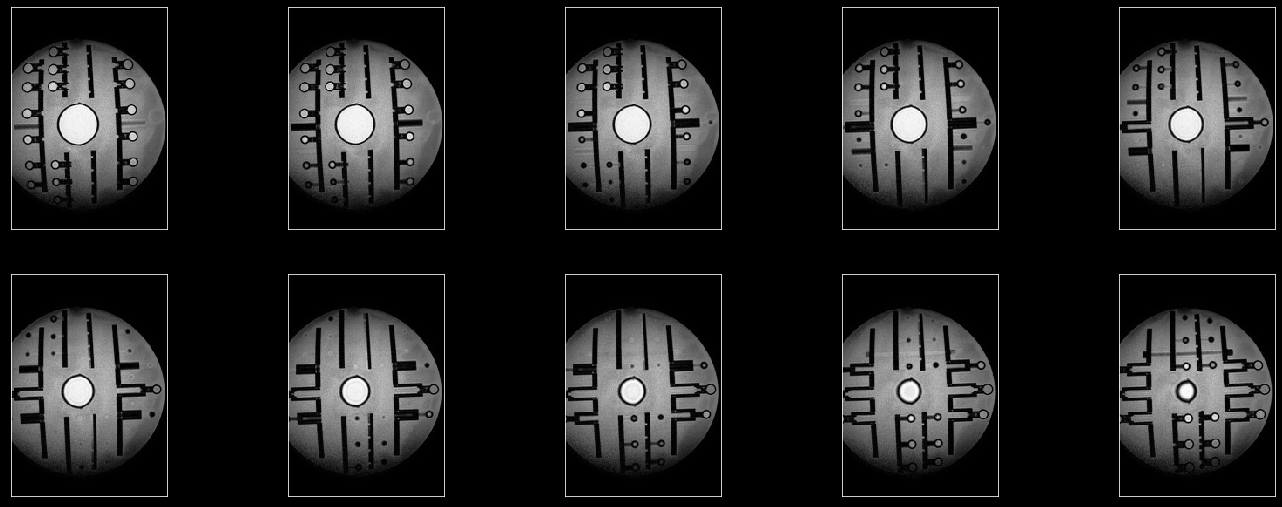

In [154]:
fig, axs = plt.subplots(2, 5, figsize=(24, 9))

for i, ax in enumerate(axs.flat):
    ax.imshow(gts[i].detach().cpu().numpy().squeeze())
    ax.set_xticks([])
    ax.set_yticks([])

# Compressed Sensing

In [182]:
# with total variation

In [183]:
from utils.kernel import *
from utils.train_loader_patches import normalize
from resize.scipy import resize
from utils.ilo import *

In [348]:
fwhm = fwhm_needed(1, 4)
std = fwhm_to_std(fwhm)
slice_profile = gaussian(M=17, std=std, sym=True).astype(np.float32)
A = DegradationKernel(scale_factor=1/4, blur_kernel=slice_profile, device=device, mode='linear').to(device)

In [349]:
def mse(a, b):
    return ((a - b) ** 2).sum()

In [436]:
# set up observation to initialize z
lr_fpath = Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")
lr_vol = nib.load(lr_fpath).get_fdata(dtype=DTYPE)
obs = lr_vol[128]

pad = 19
scale = 4
obs = np.pad(obs, ((0, 0), (pad, 0)))
obs, orig_min, orig_max = normalize(obs)

obs_interp = resize(obs, (1, 1/scale), order=5)
obs_interp = torch.from_numpy(obs_interp).unsqueeze(0).unsqueeze(1).to(device)

obs = torch.from_numpy(obs).to(device)

In [437]:
G = nn.Sequential(*list(model.decoder.children()))
# ensure G is frozen
for p in G.parameters():
    p.requires_grad=False

In [438]:
N_ILO_LAYERS = 4
lrs = [1e-3, 1e-1, 1e-1, 1e-1]
n_iters = [500, 100, 100, 100]

R = 3
l1_epsilons = [10000, 20000, 40000]

In [439]:
z_init = model.encoder(obs_interp)
# z_init = torch.randn((1, 768, 8, 8), device=device)

In [440]:
preds = ilo(G, z_init, obs, A, lrs, n_iters, N_ILO_LAYERS, R, l1_epsilons, pad, scale, device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/remedios/miniconda3/envs/kaisr/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
########## CSGM Layer 0 ##########


100%|███████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 41.77it/s, loss=678.4118, mse=0.0783, lpips=0.1875, tv=678.1460]


########## L1 Ball Layer 1 ##########


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 466.67it/s, mse=0.0002]


########## CSGM Layer 1 ##########


100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.27it/s, loss=66.7056, mse=0.3155, lpips=0.4871, tv=65.9030]


########## L1 Ball Layer 2 ##########


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 449.07it/s, mse=0.0000]


########## CSGM Layer 2 ##########


100%|███████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s, loss=145.9950, mse=0.2743, lpips=0.4486, tv=145.2722]


########## L1 Ball Layer 3 ##########


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 660.97it/s, mse=0.0000]


########## CSGM Layer 3 ##########


100%|███████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.54it/s, loss=202.5367, mse=0.2458, lpips=0.4229, tv=201.8680]


########## L1 Ball Layer 4 ##########


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 494.29it/s, mse=0.0380]


# Evalution

In [441]:
gt_vol = nib.load(Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-01mm_resampled.nii")).get_fdata(dtype=DTYPE)
gt = gt_vol[128]
gt, *_ = normalize(gt)

In [442]:
mses_by_ilo = []
mses_in_kernel_space = []

Auto-encoded MSE: 780.96936


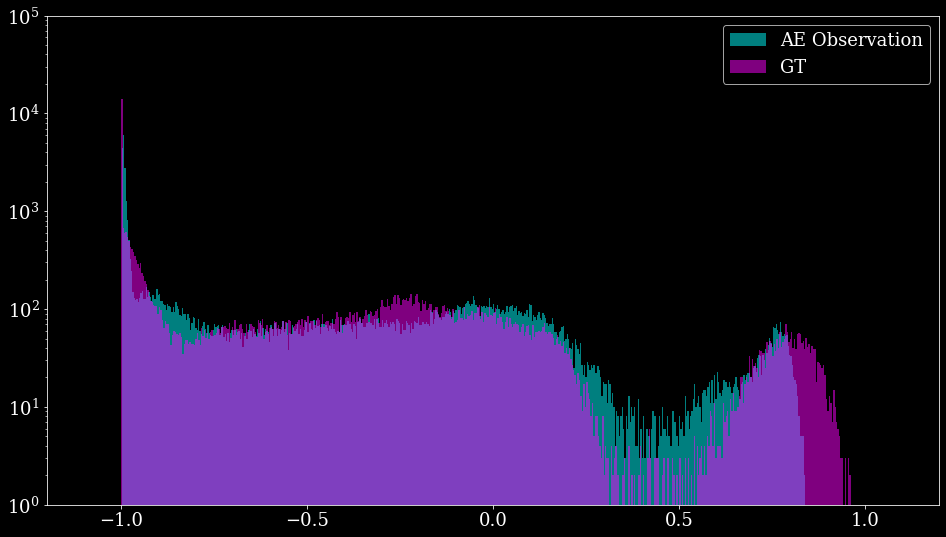

Interp MSE: 755.8278


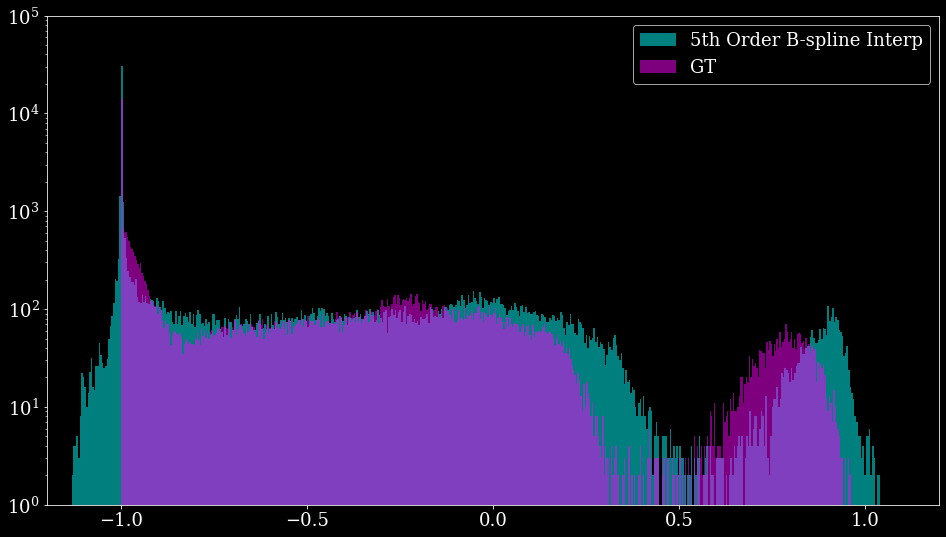

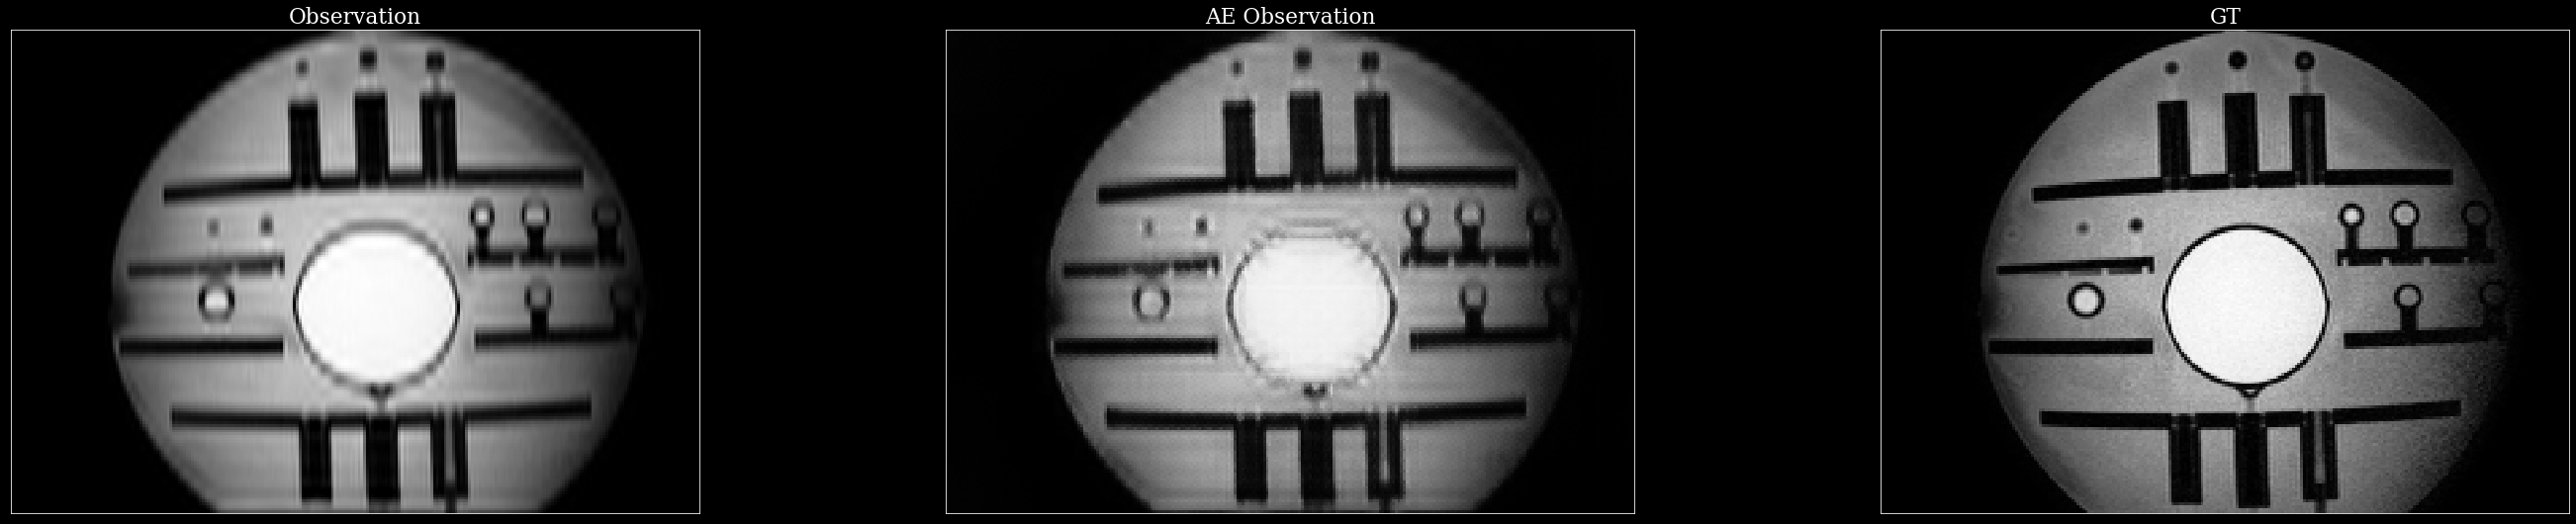

========== ILO at level 0 ==========
SR MSE: 780.96936


========== ILO at level 1 ==========
SR MSE: 762.66425


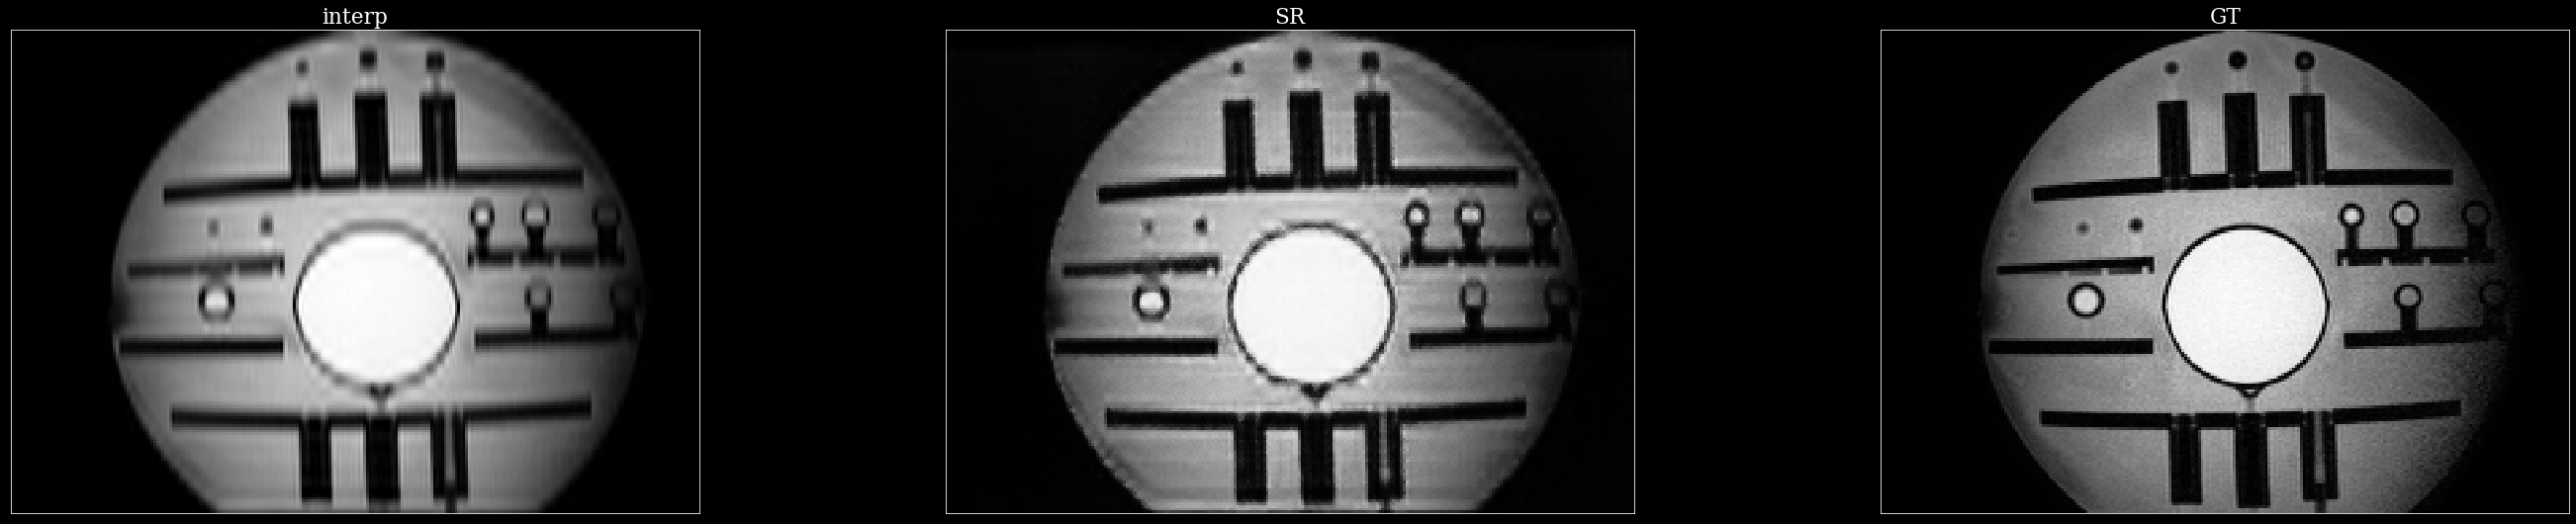

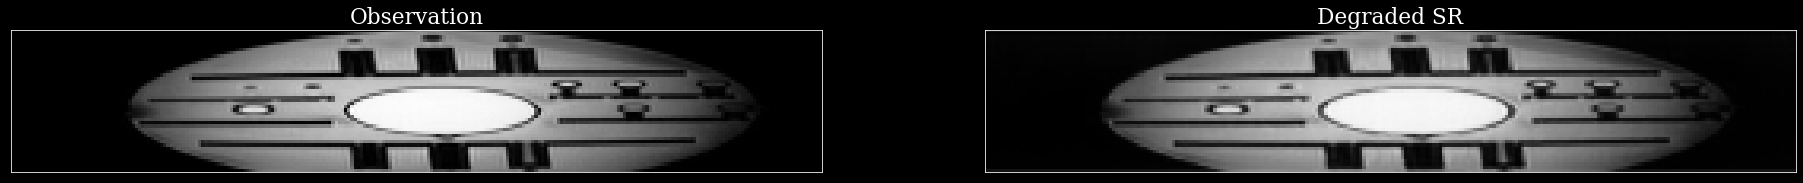

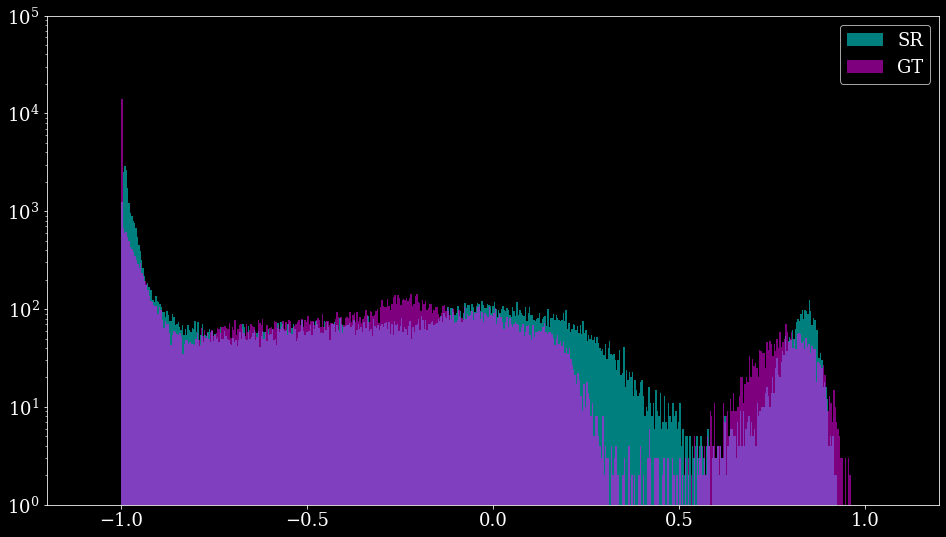

========== ILO at level 2 ==========
SR MSE: 877.20306


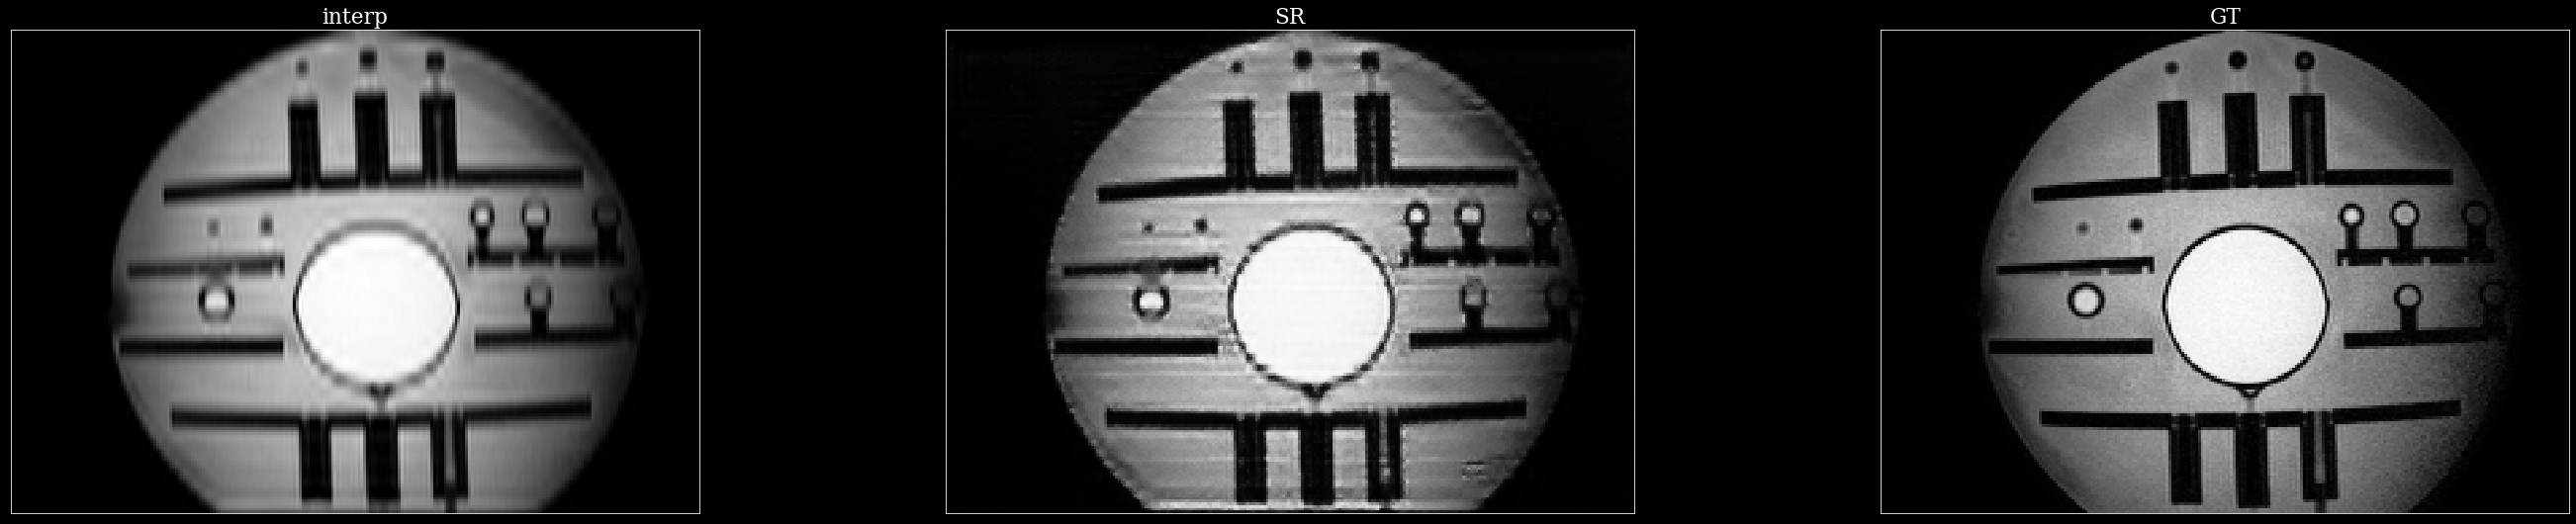

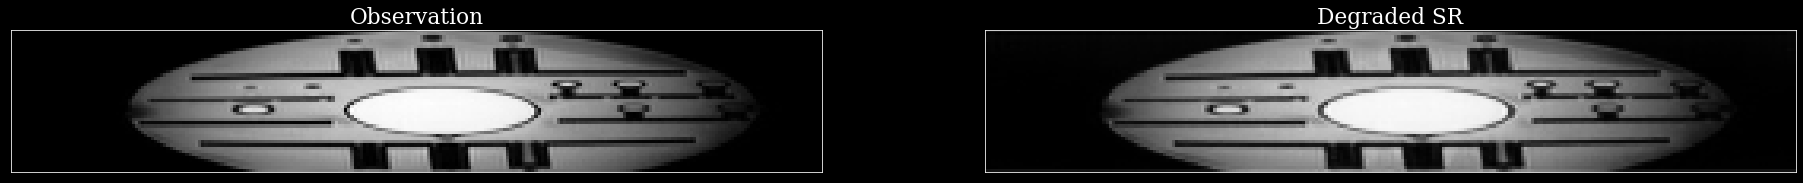

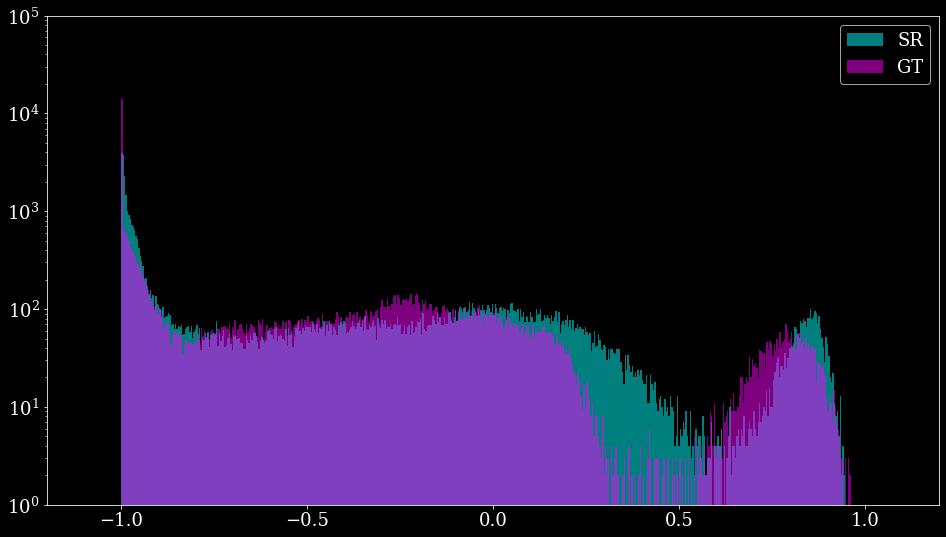

========== ILO at level 3 ==========
SR MSE: 872.86566


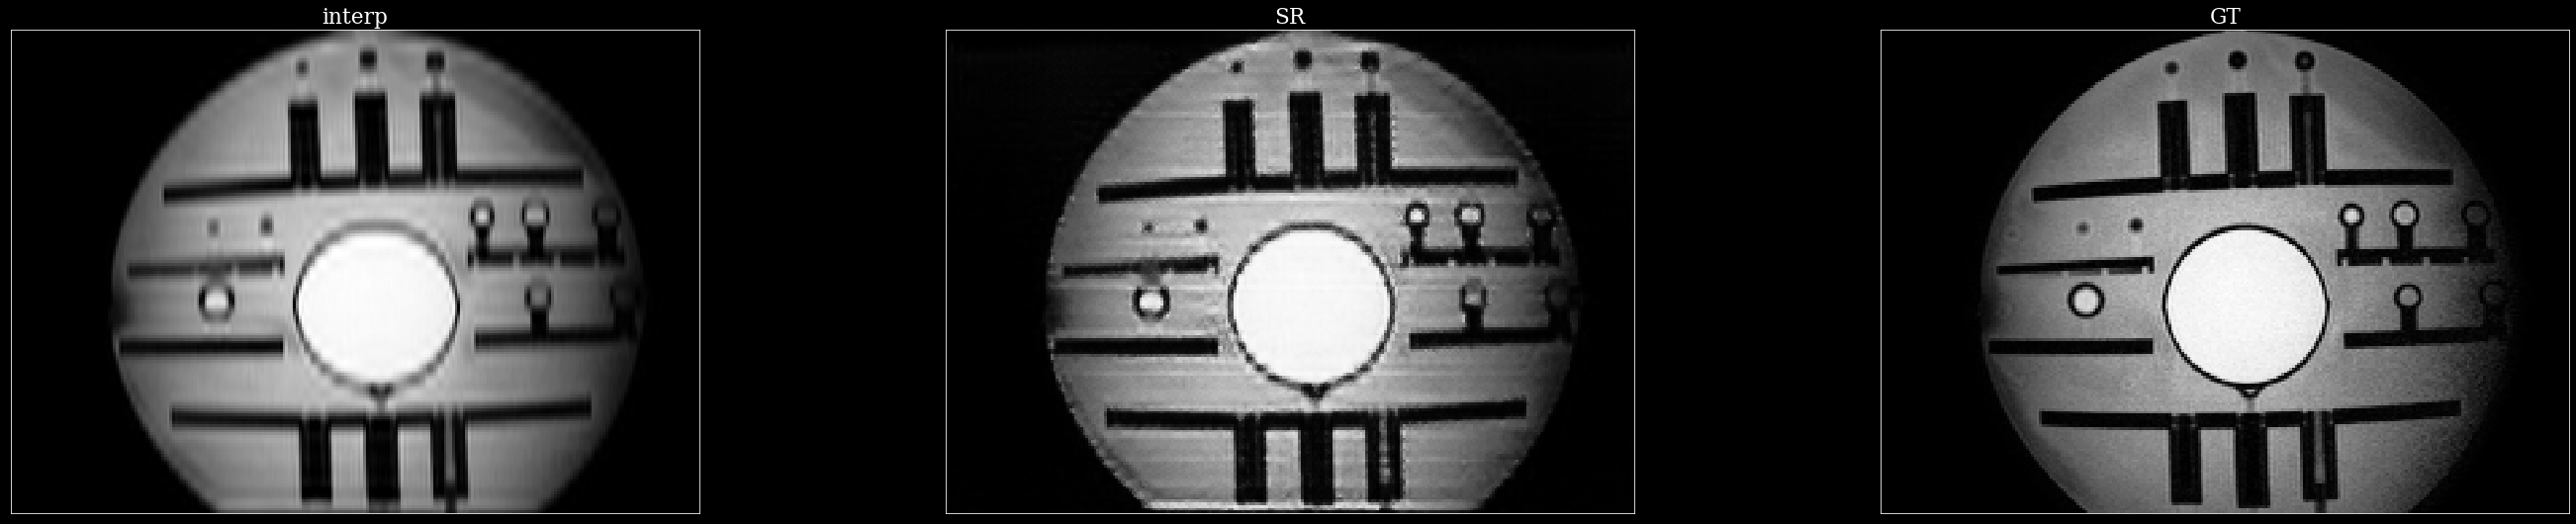

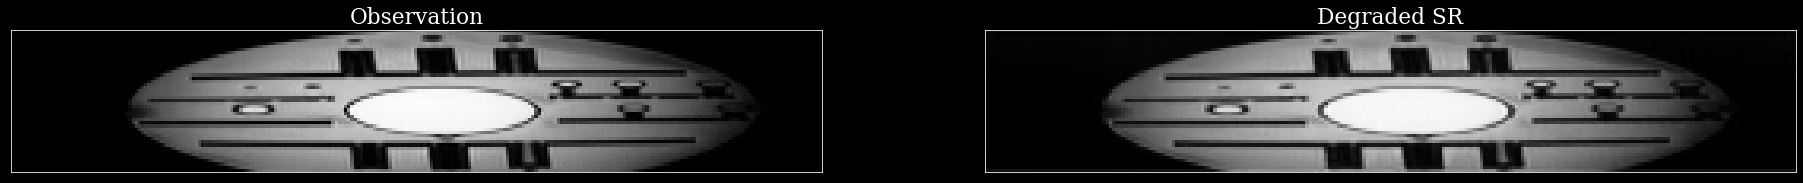

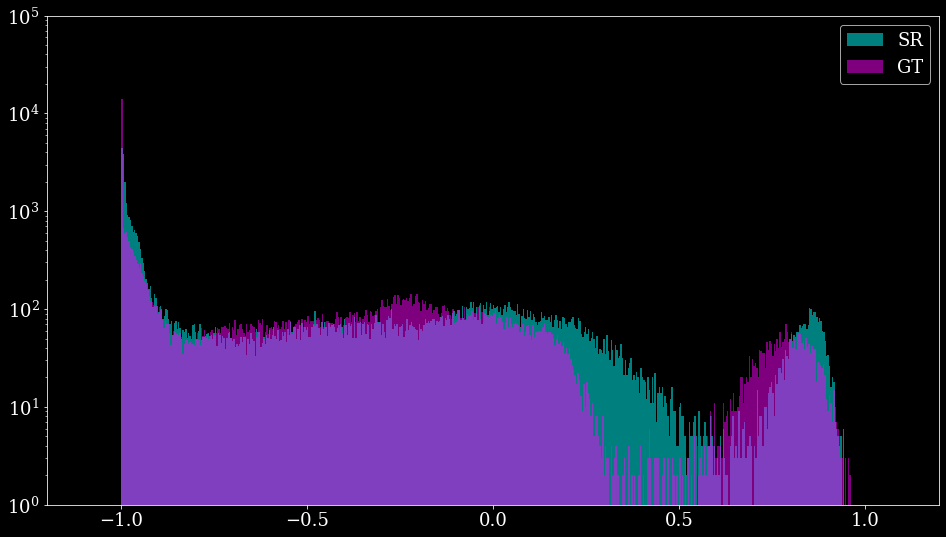

========== ILO at level 4 ==========
SR MSE: 763.73175


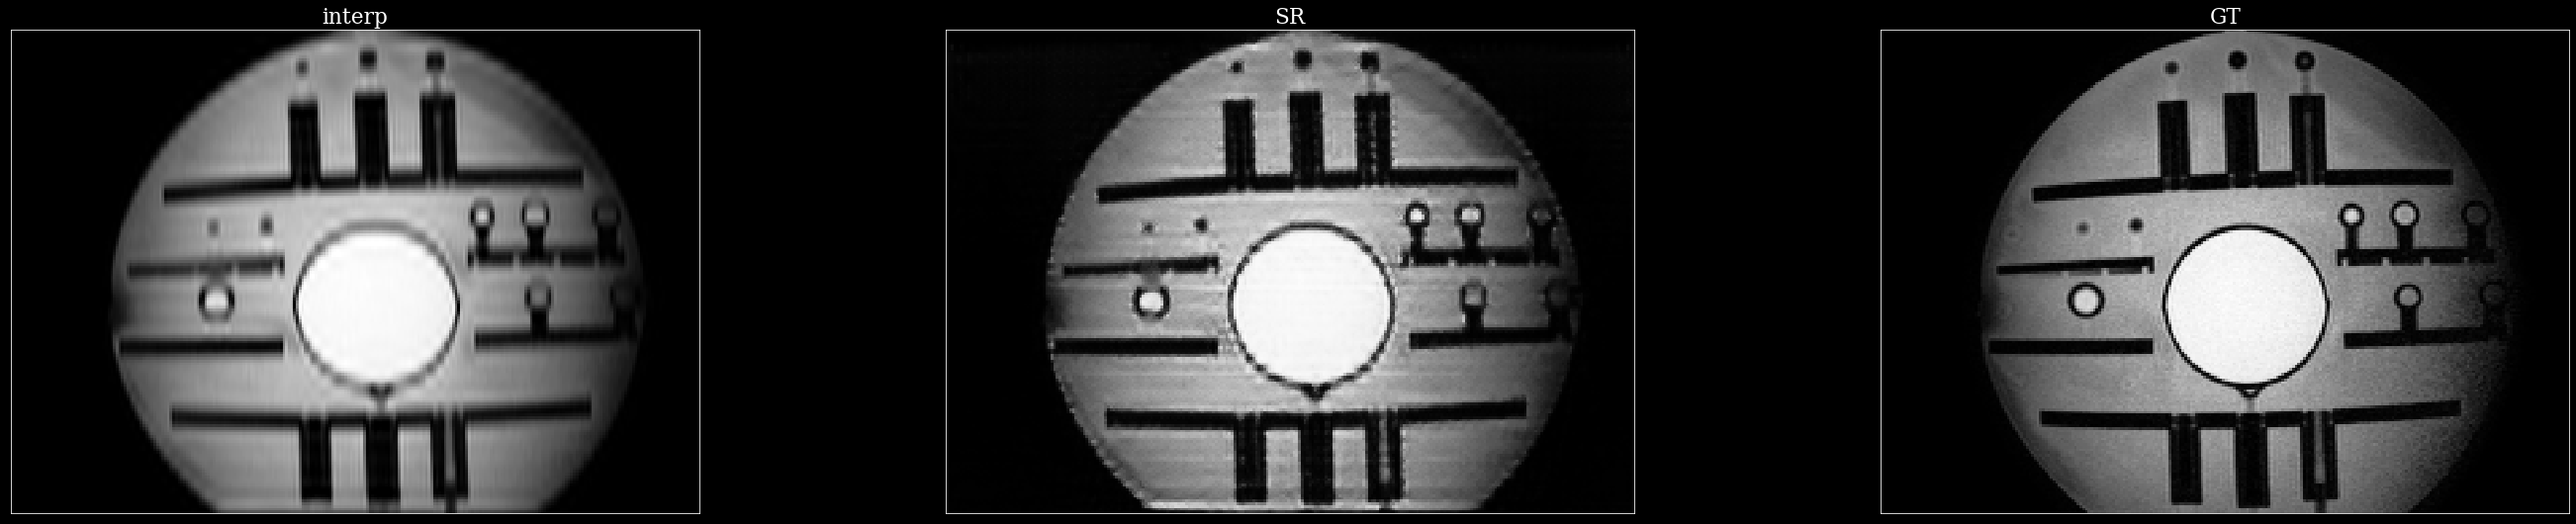

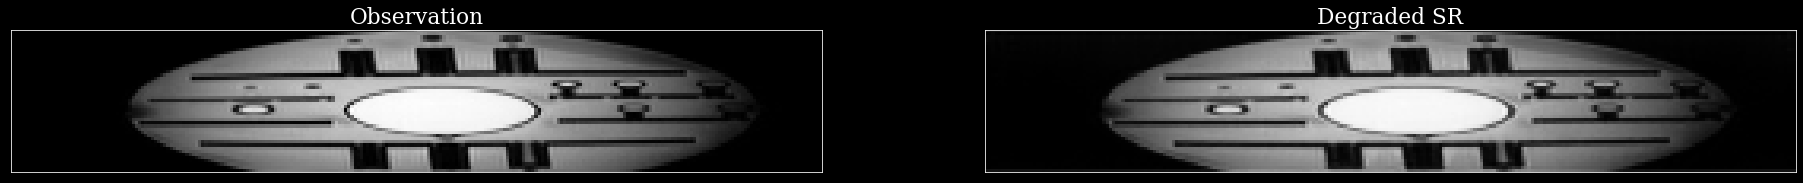

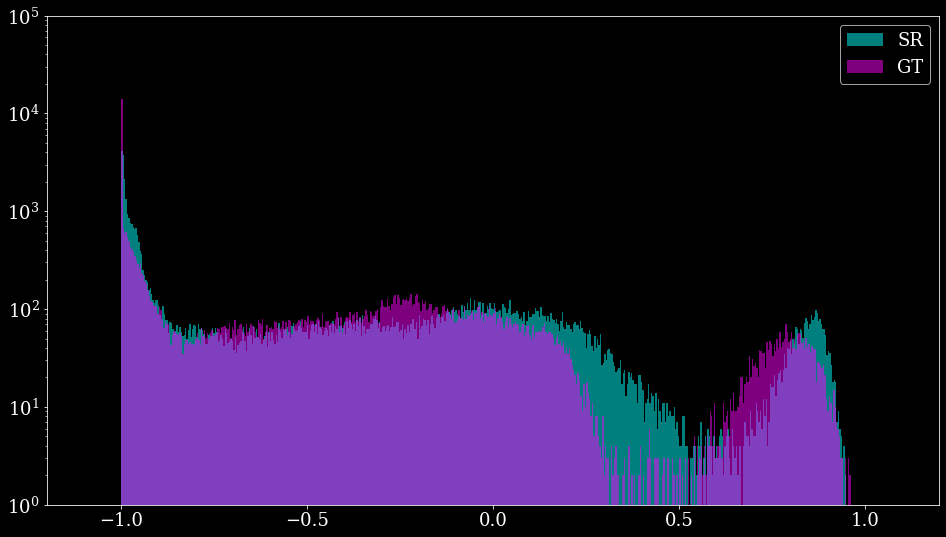

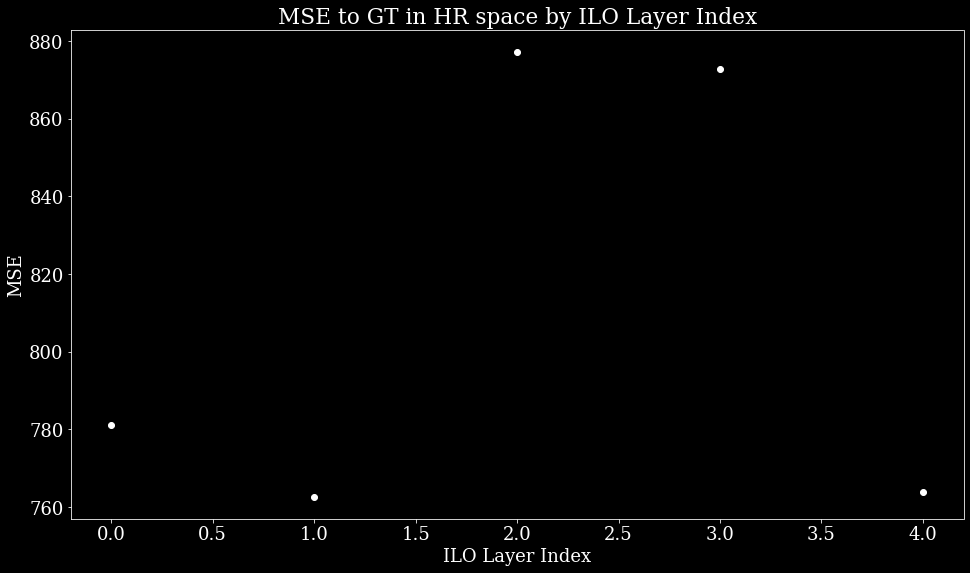

In [443]:
vmin = gt.min()
vmax = gt.max()

ae_obs = model(obs_interp).detach().cpu().numpy().squeeze()[:, int(pad*scale):]

print("Auto-encoded MSE:", mse(ae_obs, gt))
plt.hist(ae_obs.flatten(), bins=512, color='cyan', alpha=0.5, label='AE Observation')
plt.hist(gt.flatten(), bins=512, color='magenta', alpha=0.5, label='GT')
plt.yscale('log')
plt.legend()
plt.xlim((-1.2, 1.2))
plt.ylim((1, 10**5))
plt.show()

print("Interp MSE:", mse(obs_interp.detach().cpu().numpy().squeeze()[:, int(pad*scale):], gt))
plt.hist(obs_interp.detach().cpu().numpy().flatten(), bins=512, color='cyan', alpha=0.5, label='5th Order B-spline Interp')
plt.hist(gt.flatten(), bins=512, color='magenta', alpha=0.5, label='GT')
plt.yscale('log')
plt.legend()
plt.xlim((-1.2, 1.2))
plt.ylim((1, 10**5))
plt.show()

multiplot(
    [obs_interp.detach().cpu().numpy().squeeze()[:, int(pad*scale):], ae_obs, gt],
    titles=['Observation', 'AE Observation', 'GT'],
    vmins=[vmin, vmin, vmin],
    vmaxs=[vmax, vmax, vmax],
)


for i, pred in enumerate(preds):
    print("="*10, f"ILO at level {i}", "="*10)
    pred_mse = mse(pred, gt)
    mses_by_ilo.append(pred_mse)
    print("SR MSE:", pred_mse)
    multiplot(
        [obs_interp.detach().cpu().numpy().squeeze()[:, int(pad*scale):], pred, gt],
        titles=['interp', 'SR', 'GT'],
        vmins=[vmin, vmin, vmin],
        vmaxs=[vmax, vmax, vmax],
    )
    
    multiplot(
        [
            obs.detach().cpu().numpy().squeeze()[:, int(pad):], 
            A(torch.from_numpy(pred).unsqueeze(1).to(device)).detach().cpu().numpy().squeeze(),
        ],
        titles=['Observation', 'Degraded SR'],
        vmins=[vmin, vmin],
        vmaxs=[vmax, vmax],
    )
    
    mses_in_kernel_space.append(mse(
        obs.detach().cpu().numpy().squeeze()[:, int(pad):], 
        A(torch.from_numpy(pred).unsqueeze(1).to(device)).detach().cpu().numpy().squeeze(),
    ))
    
    plt.hist(pred.flatten(), bins=512, color='cyan', alpha=0.5, label='SR')
    plt.hist(gt.flatten(), bins=512, color='magenta', alpha=0.5, label='GT')
    plt.yscale('log')
    plt.xlim((-1.2, 1.2))
    plt.ylim((1, 10**5))
    plt.legend()
    plt.show()
    
plt.scatter(x=range(len(mses_by_ilo)), y=mses_by_ilo)
plt.xlabel('ILO Layer Index')
plt.ylabel('MSE')
plt.title('MSE to GT in HR space by ILO Layer Index')
plt.show()

plt.scatter(x=range(len(mses_in_kernel_space)), y=mses_in_kernel_space)
plt.xlabel('ILO Layer Index')
plt.ylabel('MSE')
plt.title('MSE to Observation in Kernel/LR space by ILO Layer Index')
plt.show()

In [444]:
# what if we autoencode the gt slice? How good are we?

In [445]:
ae_gt = model(
    torch.from_numpy(np.pad(gt, ((0, 0), (76, 0)))).unsqueeze(0).unsqueeze(1).to(device)
).detach().cpu().numpy().squeeze()[:, 76:]

multiplot([ae_gt, gt], ['AE', 'GT'])

print("Auto-encoded GT MSE:", mse(ae_gt, gt))
plt.hist(ae_gt.flatten(), bins=512, color='cyan', alpha=0.5, label='AE Observation')
plt.hist(gt.flatten(), bins=512, color='magenta', alpha=0.5, label='GT')
plt.yscale('log')
plt.legend()
plt.xlim((-1.2, 1.2))
plt.ylim((1, 10**5))
plt.show()

Auto-encoded GT MSE: 275.19226
